In [158]:
"""
Copyright (c) 2022 Magdalena Fuentes, Bea Steers, Luca Bondi(Robert Bosch GmbH), Julia Wilkins
All rights reserved.

This source code is licensed under the BSD-3-Clause license found in the
LICENSE file in the root directory of this source tree.
"""

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import os
import librosa
from librosa import display
from itertools import cycle
import IPython
from moviepy.editor import AudioFileClip,VideoFileClip,CompositeVideoClip, VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from matplotlib.patches import Rectangle
import glob
import h5py

import sys
sys.path.append('../')
from eval import iou_score, giou_score

# Explore TAU2021 File Index

## How to use this notebook:
**Note**: There are a handful of helper functions below that will be used throughout. Don't worry about these unless they need to be changed - keep scrolling!
1. In the cell below "Load index JSON", pass in your index filepath and run that cell.
2. Also enter your filepath for the annotations files in the "Also load annotations files" cell section and run this cell.
3. Customize any parameters (i.e. FOV, number of regions, etc).
4. The index is formatted with UIDs as keys. Pick the UID you want to explore in the "Visualize annotations from index and original data" section. Run this cell.
5. Now you are ready to visualize everything about the current file you've selected. Run all of the following cells and explore.

In addition to exploring the ground truth index data, we can also visualize **predictions** and view the corrsponding IOU/GIOU scores for those examples in the final section here. 

### Helper Functions (ignore)

In [5]:
def load_index(index_filepath):
    """
    Currently, one of:
        - "TAU2021_final.json": index used for initial training/predictions (per Julia MIR project)
        - "TAU2021_after_max_box_filtering.json": new index used when only the largest 
            bounding box per class/frame is considered
    
    """
    INDEX_PATH = Path(os.path.join('', index_filepath)) # PASS IN YOUR INDEX FILEPATH HERE
    index = pd.read_json(INDEX_PATH).transpose()
    with INDEX_PATH.open() as f:
        index = json.load(f)

    df_index = pd.DataFrame.from_dict(index,orient='index')
    df_index.head()
    print("Length of index: ", len(index))
    return index

def load_predictions(predictions_folder_path):
    """ 
    Currently, one of:
        - "predictions/": 6 sec batches, center-point estimation
        - "predictions_box/": 6 sec batches, box-wise estimation 
        - "predictions_box_8sec/": 8 sec batches, box-wise estimation
        - "predictions_max_box/": 8 sec batches, box-wise estimation, 
            only considers largest bounding box per class/frame (**different index file)
        
    """
    model_predictions = np.array(glob.glob(os.path.join(predictions_folder_path, "**", "*.h5")))

    pred = {}
    print("Current prediction files: ")
    for file_path in model_predictions:
        print(file_path)
        with h5py.File(file_path,'r' ) as f:
            for uid in f.keys():
                pred[uid] = {
                    'time': np.array(f[uid]['time']),
                    'pred': np.array(f[uid]['pred']),
                }
    print("Length of predictions: ", len(pred))
    return pred

# Helper function for azimuth to region for plots
def azimuth_to_region(azimuth, fov=120, num_regions=15):
    idx = np.round(
        (azimuth + fov / 2) / fov * (num_regions - 1)
    ).astype(int)
    idx = np.clip(idx, 0, num_regions - 1)
    return idx

def score_file(index_data, 
               predictions_data, 
               uid, 
               tau,
               pointwise_or_boxwise,
               class_list=['bus', 'car', 'motorbike', 'truck'],
               frame_type='all',
               fps=2, 
               fov=120, 
               verbose=False):
    """
    Get a dataframe of per-class IOU and GIOU scores for a given file UID.
    
    Args:
        index_data: Ground truth data (dict), indexed by UID.
        predictions_data: Predictions data (dict), indexed by UID.
        uid: File UID (found both in the index and prediction file)
        tau: Threshold used to binarize predictions.
        class_list: List of classes for the model.
        frame_type: Type of frames to evaluate for this file. 
            One of: 
                -'all' (includes active and inactive frames)
                -'active' (ground truth has something)
                -'inactive' (ground truth is empty)
        fps: Frames per second.
        fov: Video field of view.
        verbose: If true, print more details about the frame-by-frame scoring.
    """
    
    file_index = index_data[uid]
    file_pred = predictions_data[uid]
    overall_per_class_scores = []
    overall_per_class_scores_giou = []
    
    # Frames, classes, regions
    f, c, r = file_pred['pred'].shape
    mask_per_class = file_pred['pred'].reshape((c, f, r))

    # Initialize scores dict for this file
    class_score = {c: None for c in class_list}
    giou_class_score = {c: None for c in class_list}

    # Loop through the classes present in this file
    for class_index, class_name in enumerate(class_list):
        if verbose: 
            print("CURRENT CLASS: ", class_name)

        # Get all events of this class
        events_for_this_class = [d for d in file_index['events'] if d['label'] == class_name]

        frame_scores = []
        giou_frame_scores = []

        # Loop through time
        for f, t in enumerate(np.arange(0, 10, 1/fps)): 
            # For a given time frame, collect all indexes of this class and their azimuth indexes

            # Initialize box of region size (1D) - one box per frame
            box = np.zeros((1, r))

            # For each event in this class
            for event in events_for_this_class:
                if event['source'] == 'video':

                    # Basically a way of checking to see if the current events time
                    # array matches with a loop through possible timeframes
                    if any(np.abs(t-event['time']) < 1/fps):

                        # Get index to look for in azmith array
                        idx = np.argmin(np.abs(t-event['time']))

                        if pointwise_or_boxwise == 'boxwise':
                            # BOXWISE SCORING
                            event_aximuth_idxs_r = np.round((event['azimuth_right'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)
                            event_aximuth_idxs_l = np.round((event['azimuth_left'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)
                            try:
                                box[:,event_aximuth_idxs_l:event_aximuth_idxs_r+1] = 1
                            except:
                                invalid_files.append(uid)
                        elif pointwise_or_boxwise == 'pointwise':
                            # POINTWISE SCORING
                            event_azimuth_idxs = np.round((event['azimuth'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)
                            try:
                                box[:,event_azimuth_idxs] = 1
                            except:
                                invalid_files.append(uid)
                        else:
                            raise Exception("pointwise_or_boxwise argument should be one of ['pointwise', 'boxwise']")
                            
                        
            if verbose: 
                print("TIME: ", t)
                print("GT BOX MASK: ", box)
                print("PRED BOX MASK: ", (mask_per_class[class_index,f,None]>tau)**1)#mask_per_class[class_index,f,None])#, #mask_per_class[class_index,f,None])#(mask_per_class[class_index,f,None]>tau)**1)

            # One score per frame per class
            iou_res = iou_score(pred_mask=mask_per_class[class_index,f,None], # the pred is many instances
                              gt_bbox_coords=[], 
                              gt_box_mask=box, 
                              th=tau, 
                              frame_size=(1, r))

            giou_res = giou_score(pred_mask=(mask_per_class[class_index,f,None]>tau)**1, # the pred is many instances
                                      gt_mask=box, 
                                      th=tau, 
                                      frame_size=(1, r))
            
            if verbose:
                print("IOU Score: ", iou_res[0])
                print("GIOU Score: ", giou_res[0], "\n")

            # Add this to the scores list
            # Inactive
            if frame_type == 'all':
                frame_scores.append(iou_res[0])
                giou_frame_scores.append(giou_res[0])
            elif frame_type == 'active':
                if not np.all((iou_res[1] == 0)):
                    frame_scores.append(iou_res[0])
                    giou_frame_scores.append(giou_res[0])
            elif frame_type == 'inactive':
                if np.all((iou_res[1] == 0)):
                    frame_scores.append(iou_res[0])
                    giou_frame_scores.append(giou_res[0])
            else:
                raise ValueError('frame_type should be "active", "inactive", or "all"')
                

        class_score[class_name] = frame_scores
        giou_class_score[class_name] = giou_frame_scores

    avgs = [np.mean(element) for element in class_score.values()]
    overall_per_class_scores.append(avgs)

    avgs_giou = [np.mean(element) for element in giou_class_score.values()]
    overall_per_class_scores_giou.append(avgs_giou)

    cols = class_list + ['Score'] + ['Tau']
    overall_per_class_scores[0] += ['IOU']
    overall_per_class_scores[0] += [tau]
    overall_per_class_scores_giou[0] += ['GIOU']
    overall_per_class_scores_giou[0] += [tau]
    
    iou_scoring_df = pd.DataFrame(overall_per_class_scores, columns=cols)
    giou_scoring_df = pd.DataFrame(overall_per_class_scores_giou, columns=cols)
    
    final = pd.concat([iou_scoring_df, giou_scoring_df])
    return final

def get_classes(index):
    c = set()
    for uid, file_dict in index.items():
        for event in file_dict['events']:
            c.add(event['label'])
    # Discard audio label for off_screen_vehicle, it will not appear in ground truth
    # as audio is only used as a filter for video labels
    c.discard('offscreen')
    c.discard('-1')
    c = sorted(c)
    return c

### Load index JSON
Add your filepath below!

In [210]:
index = load_index("../index/Urbansas.json")

Length of index:  1080


In [211]:
# Get all keys in the current index
print(index.keys())

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', 

### Load annotations files 
Put your filepath below!

In [12]:
# Also load up the original annotations files
URBANSASPATH = '/Users/mf3734/sound_datasets/urbansas/'
audio_annotations_df = pd.read_csv(os.path.join(URBANSASPATH, 'annotations/audio_annotations.csv'))
video_annotations_df = pd.read_csv(os.path.join(URBANSASPATH, 'annotations/video_annotations.csv'))

In [13]:
# Classes to be used in visualizations and scoring below
# classes = list(set(video_annotations_df['label']))[::-1]
# classes.sort()
# print(classes) # Note that from the video annotations, this includes "-1", however the predictions don't include -1

# Get the classes dynamically as the code does in BatchRawDataset
classes = get_classes(index)
print(classes)

['bus', 'car', 'motorbike', 'truck']


### Customize parameters to be used throughout notebook

In [82]:
# Params
frame_width = 1280
fov_h = 120
num_regions = 5
start = 0
end = 10
labels_period = 0.5

# Define our angles
angles = np.linspace(-fov_h/2, fov_h/2, num_regions)

## Visualize annotations from index and original data
- Visualize original waveform
- Visualize sptectrogram
- Play original waveform
- Visualize audio annotations over the spectrogram

In [159]:
# Find UID of a filename
for k,v in index.items():
    if v['path'] == 'audio/street_traffic-lyon-1045-41811.wav':
        print(k)

853


In [160]:
# Get current file data
uid = '1' # PICK YOUR UID HERE
curr_audio_filepath = os.path.join(URBANSASPATH, index[uid]['path'])
curr_video_filepath = os.path.join(URBANSASPATH, 'video/' + index[uid]['path'].split('/')[1].split('.')[0] + '.mp4')
curr_video_annotations = [i for i in index[uid]['events'] if i['source'] == 'video']
curr_audio_annotations = [i for i in index[uid]['events'] if i['source'] == 'audio']
print(curr_audio_filepath, curr_video_filepath)

/Users/mf3734/sound_datasets/urbansas/audio/acevedo0103_00_1.wav /Users/mf3734/sound_datasets/urbansas/video/acevedo0103_00_1.mp4


File:  /Users/mf3734/sound_datasets/urbansas/audio/acevedo0103_00_1.wav


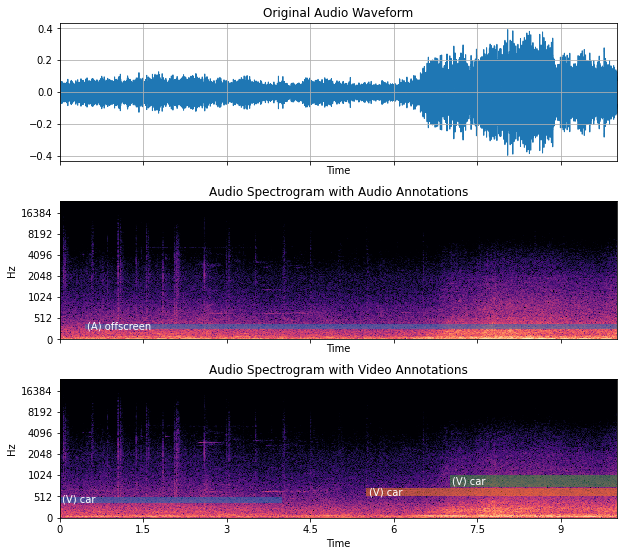

In [161]:
# Load original audio and play it
print("File: ", curr_audio_filepath)
file_audio, file_sr = librosa.load(curr_audio_filepath,sr=None,mono=True)#offset=start,duration=end-start)
IPython.display.display(IPython.display.Audio(file_audio,rate=file_sr))

fig, axs = plt.subplots(3,1, figsize=(9,8), sharex='all')
fig.tight_layout(pad=3.0)

# Plot waveform
plt.sca(axs[0])
plt.title("Original Audio Waveform")
librosa.display.waveshow(file_audio,sr=file_sr)
plt.grid()

# Plot spectrogram
plt.sca(axs[1])
plt.title("Audio Spectrogram with Audio Annotations")
file_audio_stft = librosa.stft(file_audio)
file_audio_specgram = librosa.amplitude_to_db(np.abs(file_audio_stft), ref=np.max)
librosa.display.specshow(file_audio_specgram,sr=file_sr,y_axis='mel',x_axis='time')

# Add annotations
bar_height = 0.4
bar_bottom_it = cycle(2**np.arange(8,15,0.5))

# Add audio annotations
plt.sca(axs[1])
for event in curr_audio_annotations:
    ev_start = event['start']
    ev_end = event['end']
    
    if ev_start < end and ev_end > start:
        ctr = (ev_start+ev_end)/2
        width = ev_end-ev_start
        bottom = next(bar_bottom_it)
        height = bar_height*bottom
        plt.bar(x=ctr,width=width,bottom=bottom,height=height,alpha=0.5)
        plt.text(ev_start+0.05,bottom+height/2,f'({event["source"][:1].upper()}) {event["label"]}',
                 color='w',va='center')
        
# Plot spectrogram
plt.sca(axs[2])
plt.title("Audio Spectrogram with Video Annotations")
file_audio_stft = librosa.stft(file_audio)
file_audio_specgram = librosa.amplitude_to_db(np.abs(file_audio_stft), ref=np.max)
librosa.display.specshow(file_audio_specgram,sr=file_sr,y_axis='mel',x_axis='time')

# Add video annotations
plt.sca(axs[2])
for event in curr_video_annotations:
    ev_start = event['time'][0]
    ev_end = event['time'][-1] + labels_period
    
    if ev_start < end and ev_end > start:
        ctr = (ev_start+ev_end)/2
        width = ev_end-ev_start
        bottom = next(bar_bottom_it)
        height = bar_height*bottom
        plt.bar(x=ctr,width=width,bottom=bottom,height=height,alpha=0.5)
        plt.text(ev_start+0.05,bottom+height/2,f'({event["source"][:1].upper()}) {event["label"]}',
                 color='w',va='center')

# Visualize Ground Truth (from video annotations primarily)

## Center-point Estimation

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


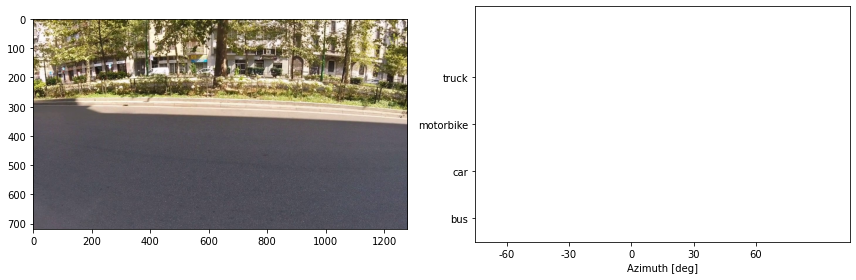

In [83]:
# This will show the video side-by-side with the regions moving through the video
file_video = VideoFileClip(str(curr_video_filepath)).set_start(start).set_end(end)
fig,axs = plt.subplots(1,2,figsize=(12,4))

def make_frame(frame_time:float):
    axs[0].clear()
    axs[0].imshow(file_video.get_frame(frame_time))

    axs[1].clear()
    axs[1].set_ylim(-0.5, len(classes)+0.5)
    axs[1].set_xlim(-0.5,num_regions+0.5)
    axs[1].set_yticks(np.arange(len(classes)))
    axs[1].set_yticklabels(classes)
    axs[1].set_xticks(np.arange(len(angles)))
    axs[1].set_xticklabels([ f'{a:.0f}' for a in angles])
    axs[1].set_xlabel('Azimuth [deg]')

    # For every event in this files video annotations
    # Look for azimuth and label at this
    cmap = ['red', 'blue', 'green', 'yellow', 'orange']

    # !!!!!!! Note here that we're passing in curr_video_annotations
    # This is computed above, it's a list of video "events" from the index file originally
    for i in curr_video_annotations:
        for ind, t in enumerate(i['time']):
            if t == frame_time:
                curr_azimuth = i['azimuth'][ind]
                curr_label = i['label']
                curr_region = azimuth_to_region(curr_azimuth)-0.5
                curr_label_lookup = classes.index(curr_label)-0.5
                # Get azimuth and class at current time
                axs[1].add_patch(Rectangle((curr_region, curr_label_lookup), 1, 1, alpha=0.5, 
                                       color=cmap[int(curr_label_lookup)])) 
    plt.tight_layout()

    return mplfig_to_npimage(fig)

# Render and display
file_audio_clip = AudioFileClip(str(curr_audio_filepath)).set_start(start).set_end(end)
file_video_pred = VideoClip(make_frame, duration=file_video.duration).set_audio(file_audio_clip)
file_video_pred.ipython_display(width=960,fps=2)


# Box-wise estimation (ground truth)

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


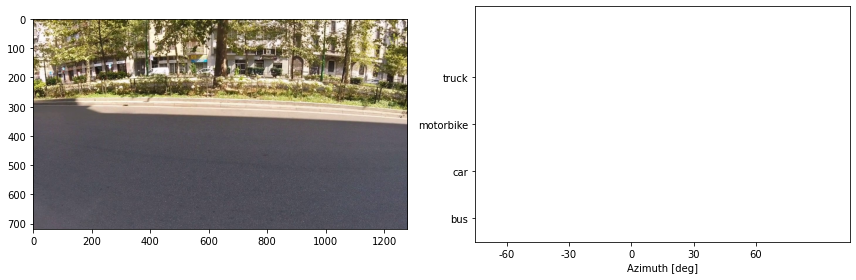

In [84]:
# This will show the video side-by-side with the regions moving through the video
file_video = VideoFileClip(str(curr_video_filepath)).set_start(start).set_end(end)
fig,axs = plt.subplots(1,2,figsize=(12,4))

def make_frame(frame_time:float):
    axs[0].clear()
    axs[0].imshow(file_video.get_frame(frame_time))

    axs[1].clear()
    axs[1].set_ylim(-0.5, len(classes)+0.5)
    axs[1].set_xlim(-0.5,num_regions+0.5)
    axs[1].set_yticks(np.arange(len(classes)))
    axs[1].set_yticklabels(classes)
    axs[1].set_xticks(np.arange(len(angles)))
    axs[1].set_xticklabels([ f'{a:.0f}' for a in angles])
    axs[1].set_xlabel('Azimuth [deg]')

    # For every event in this files video annotations
    # Look for azimuth and label at this
    cmap = ['red', 'blue', 'green', 'yellow', 'orange']

    # !!!!!!! Note here that we're passing in curr_video_annotations
    # This is computed above, it's a list of video "events" from the index file originally
    for i in curr_video_annotations:
        for ind, t in enumerate(i['time']):
            if t == frame_time:
                curr_azimuth_right = i['azimuth_right'][ind]
                curr_azimuth_left = i['azimuth_left'][ind]
                curr_label = i['label']
                
                curr_right_region = azimuth_to_region(curr_azimuth_right)-0.5
                curr_left_region = azimuth_to_region(curr_azimuth_left)-0.5
                
                curr_label_lookup = classes.index(curr_label)-0.5
                curr_box_width = curr_right_region-curr_left_region+1
                # Get azimuth and class at current time
                axs[1].add_patch(Rectangle((curr_left_region, curr_label_lookup), curr_box_width, 1, alpha=0.5, 
                                       color=cmap[int(curr_label_lookup)])) 
    plt.tight_layout()

    return mplfig_to_npimage(fig)

# Render and display
file_audio_clip = AudioFileClip(str(curr_audio_filepath)).set_start(start).set_end(end)
file_video_pred = VideoClip(make_frame, duration=file_video.duration).set_audio(file_audio_clip)
file_video_pred.ipython_display(width=960,fps=2)


# Visualize Prediction Data

### Load index and predictions

In [202]:
# index = load_index("../index/TAU2021.json")
# index = load_index("mag_debugging/TAU2021.json")
# pred = load_predictions("mag_debugging/")
pred = load_predictions("../predictions/stft_fix_3/pointwise")
# pred = load_predictions("predictions_lyon_point///")

Current prediction files: 
../predictions/stft_fix_3/pointwise/train_model-stft_fix,num_regions-5,point_sources-True,train_folds-[0,1,3,4],val_folds-2/Urbansas-f2-epoch185.h5
../predictions/stft_fix_3/pointwise/train_model-stft_fix,num_regions-5,point_sources-True,train_folds-[0,1,2,3],val_folds-4/Urbansas-f4-epoch166.h5
../predictions/stft_fix_3/pointwise/train_model-stft_fix,num_regions-5,point_sources-True,train_folds-[0,1,2,4],val_folds-3/Urbansas-f3-epoch164.h5
../predictions/stft_fix_3/pointwise/train_model-stft_fix,num_regions-5,point_sources-True,train_folds-[0,2,3,4],val_folds-1/Urbansas-f1-epoch157.h5
../predictions/stft_fix_3/pointwise/train_model-stft_fix,num_regions-5,point_sources-True,train_folds-[1,2,3,4],val_folds-0/Urbansas-f0-epoch181.h5
Length of predictions:  1080


In [203]:
classes = get_classes(index)
print(classes)

['bus', 'car', 'motorbike', 'truck']


In [ ]:
index.keys()

In [204]:
pred.keys()

dict_keys(['100', '1004', '1016', '1021', '1025', '1030', '1032', '1037', '104', '1041', '1042', '1053', '1056', '1058', '1061', '1066', '1071', '117', '12', '132', '142', '148', '15', '150', '157', '158', '16', '161', '164', '168', '169', '170', '179', '180', '185', '187', '188', '190', '194', '198', '20', '200', '212', '215', '217', '22', '232', '234', '239', '240', '242', '255', '259', '263', '264', '281', '288', '294', '299', '301', '302', '317', '32', '320', '323', '324', '328', '33', '332', '336', '340', '349', '364', '367', '369', '377', '382', '384', '387', '388', '39', '393', '395', '399', '406', '410', '411', '414', '436', '438', '441', '442', '445', '46', '460', '462', '466', '47', '475', '48', '480', '482', '483', '488', '49', '492', '494', '495', '501', '508', '52', '521', '522', '524', '53', '538', '539', '544', '545', '549', '557', '558', '564', '583', '584', '585', '587', '589', '606', '607', '617', '619', '622', '625', '628', '630', '634', '636', '637', '641', '643', '

In [26]:
folds = [(k, index[k]['fold']) for k in index.keys()]
# folds

In [51]:
# np.unique([idx for idx, video in index.items() for event in video['events'] if 'truck' in event['label'] ])

In [ ]:
# idx=0
# for idx in range(20):
#     assert ~np.any(pred['4']['pred'][idx] == pred['0']['pred'][idx])
#     plt.imshow(pred['4']['pred'][idx])
#     plt.show()
#     plt.imshow(pred['0']['pred'][idx])
#     plt.show()

### Pick the desired UID

In [205]:
# Find UID of a filename
for k,v in index.items():
    if v['path'] == 'audio/acevedo0103_00_26.wav':
        print(k)

19


In [213]:
uid = '706'#np.random.choice(list(index.keys()), size=1)[0] # Currently random  # 959
curr_audio_filepath = os.path.join(URBANSASPATH, index[uid]['path'])
curr_video_filepath = os.path.join(URBANSASPATH, 'video', f"{curr_audio_filepath.split('/')[-1].split('.')[0]}.mp4")
curr_video_annotations = [i for i in index[uid]['events'] if i['source'] == 'video']
print("UID: ", uid)
print("Current audio filepath: ", curr_audio_filepath)
print("Current video filepath: ", curr_video_filepath)
print(pred[uid]['pred'].shape)

UID:  706
Current audio filepath:  /Users/mf3734/sound_datasets/urbansas/audio/street_traffic-lisbon-1008-41508.wav
Current video filepath:  /Users/mf3734/sound_datasets/urbansas/video/street_traffic-lisbon-1008-41508.mp4
(21, 4, 5)


In [201]:
# for k,v in pred.items():
#     print(v['pred'].shape)

### Visualize...

In [207]:
# If threshold = True, visualize predicted regions over a specified tau threshold
# Otherwise, show the prediction mask as is
tau = 0.2
thresholded = True
boxwise = True
fps = 2
num_regions = pred[uid]['pred'].shape[-1]
angles = np.linspace(-fov_h/2, fov_h/2, num_regions)
print(f'number of regions {num_regions}, angles {angles}')

number of regions 5, angles [-60. -30.   0.  30.  60.]


In [199]:
# for i in range(pred[uid]['pred'].shape[0]):
#     plt.imshow(pred[uid]['pred'][i, :, :])
#     plt.show()
# #     plt.colorbar()

In [208]:
pred[uid]['time']

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [70]:
classes

['bus', 'car', 'motorbike', 'truck']

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


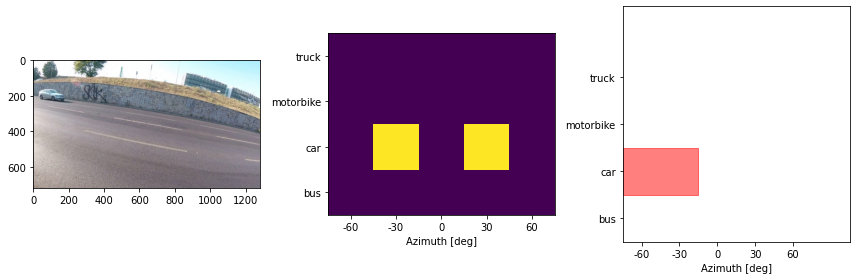

In [214]:
# This will show the video side-by-side with the regions moving through the video
file_video = VideoFileClip(str(curr_video_filepath)).set_start(start).set_end(end)
fig,axs = plt.subplots(1,3, figsize=(12,4))

def make_frame(frame_time:float):
    axs[0].clear()
    axs[0].imshow(file_video.get_frame(frame_time))

    axs[1].clear()
    
    # Pick if you want to show the thresholded version or unthresholded
    if thresholded == True:
        mask = ((pred[uid]['pred'] > tau)**1)[int(frame_time*fps), :, :]#.reshape(len(classes),12*fps,5)[:,int(frame_time*2),:]
    else:
        mask = pred[uid]['pred'][int(frame_time*fps), :, :]#.reshape(len(classes),10*fps,5)[:,int(frame_time*2),:]
    
    axs[1].imshow(mask)#, vmin=0, vmax=0.2)

    axs[1].set_ylim(-0.5, len(classes)-0.5)
    axs[1].set_xlim(-0.5,num_regions-0.5)
    axs[1].set_yticks(np.arange(len(classes)))
    axs[1].set_yticklabels(classes)
    axs[1].set_xticks(np.arange(len(angles)))
    axs[1].set_xticklabels([ f'{a:.0f}' for a in angles])
    axs[1].set_xlabel('Azimuth [deg]')
    
    
    axs[2].clear()
    axs[2].set_ylim(-0.5, len(classes)+0.5)
    axs[2].set_xlim(-0.5,num_regions+0.5)
    axs[2].set_yticks(np.arange(len(classes)))
    axs[2].set_yticklabels(classes)
    axs[2].set_xticks(np.arange(len(angles)))
    axs[2].set_xticklabels([ f'{a:.0f}' for a in angles])
    axs[2].set_xlabel('Azimuth [deg]')

    # For every event in this files video annotations
    # Look for azimuth and label at this
    cmap = ['red', 'blue', 'green', 'yellow', 'orange']
    cmap = cmap[:len(classes)]

    # !!!!!!! Note here that we're passing in curr_video_annotations
    # This is computed above, it's a list of video "events" from the index file originally
    for i in curr_video_annotations:
        for ind, t in enumerate(i['time']):
            if t == frame_time:
                if boxwise is True:
                    curr_azimuth_right = i['azimuth_right'][ind]
                    curr_azimuth_left = i['azimuth_left'][ind]
                    curr_label = i['label']
#                     print(curr_label)

                    curr_right_region = azimuth_to_region(curr_azimuth_right)-0.5
                    curr_left_region = azimuth_to_region(curr_azimuth_left)-0.5

                    curr_label_lookup = classes.index(curr_label)-0.5
                    curr_box_width = curr_right_region-curr_left_region+1
                    # Get azimuth and class at current time
                    axs[2].add_patch(Rectangle((curr_left_region, curr_label_lookup), curr_box_width, 1, alpha=0.5, 
                                           color=cmap[int(curr_label_lookup)])) 
                else:
                    curr_azimuth = i['azimuth'][ind]
                    curr_label = i['label']
                    curr_region = azimuth_to_region(curr_azimuth)-0.5
                    curr_label_lookup = classes.index(curr_label)-0.5
                    # Get azimuth and class at current time
                    axs[2].add_patch(Rectangle((curr_region, curr_label_lookup), 1, 1, alpha=0.5, 
                                       color=cmap[int(curr_label_lookup)])) 
    plt.tight_layout()

    return mplfig_to_npimage(fig)

# Render and display
file_audio_clip = AudioFileClip(str(curr_audio_filepath)).set_start(start).set_end(end)
file_video_pred = VideoClip(make_frame, duration=file_video.duration).set_audio(file_audio_clip)
file_video_pred.ipython_display(width=960,fps=fps)


In [ ]:
tau

In [47]:
score_file(index, pred, uid, tau=tau, pointwise_or_boxwise='pointwise', 
           verbose=False, frame_type='active', class_list=get_classes(index))

car Score  Tau
0  0.0   IOU  0.2
0  0.0  GIOU  0.2

## Take a look at batches

In [123]:
import sys
sys.path.append('/Users/mf3734/Documents/repos/localize_sound/data/')
sys.path.append('/Users/mf3734/Documents/repos/localize_sound/')

from BatchRawDataset import BatchRawDataset
from project_paths import index_folder, dcase2021task3root, tauuavs2021_root, dataset_root_map
import project_params

np.random.seed(123)

train_dataset = 'TAU2021'
batch_size = 10000
train_folds = [0, 1, 2, 3, 4]
num_regions = 15
fov = 120

train_db = BatchRawDataset(index_path=index_folder.joinpath(f'{train_dataset}.json'),
                                   root=dataset_root_map[train_dataset],
                                   sr=project_params.sr,
                                   batch_size=batch_size,
                                   train=False,
                                   random_shift=True,
                                   drop_batch=False,
                                   folds=train_folds,
                                   in_dur=project_params.in_dur,
                                   num_regions=num_regions,
                                   labels_period=project_params.labels_period,
                                   fov=fov,
                                   point_sources=project_params.point_sources)

train_batch = next(iter(train_db))
print(train_batch[0]['uid'])  # id as in index
print(train_batch[0]['audio'].shape)  # audio signal
print(train_batch[0]['in_time'].shape, train_batch[0]['out_time'].shape)  # input and output time stamps
print(train_batch[1].shape)  # this is the gth used for training
print(train_batch[0]['out_time'])

['2' '2' '8' ... '1076' '1079' '1079']
(1564, 2, 144000)
(1564, 144000) (1564, 12)
(1564, 12, 4, 15)
[[0.  0.5 1.  ... 4.5 5.  5.5]
 [6.  6.5 7.  ... nan nan nan]
 [0.  0.5 1.  ... 4.5 5.  5.5]
 ...
 [6.  6.5 7.  ... nan nan nan]
 [0.  0.5 1.  ... 4.5 5.  5.5]
 [6.  6.5 7.  ... nan nan nan]]


In [124]:
print('num_batches', train_db.num_batches)
print('num_samples', train_db.num_samples)

num_batches 1
num_samples 2160


In [125]:
print(len(np.unique(train_batch[0]['uid'])))
np.sort([int(x) for x in np.unique(train_batch[0]['uid'])])

782


array([   2,    8,    9,   10,   11,   13,   14,   15,   16,   17,   19,
         20,   21,   23,   24,   25,   26,   30,   31,   35,   36,   37,
         38,   39,   40,   42,   47,   48,   49,   50,   53,   54,   58,
         60,   61,   62,   63,   71,   73,   75,   76,   78,   80,   81,
         84,   86,   87,   88,   90,   91,   92,   93,   94,   95,   96,
         97,   98,   99,  101,  102,  104,  105,  106,  107,  109,  110,
        112,  113,  116,  117,  120,  121,  122,  123,  125,  127,  128,
        129,  130,  131,  133,  134,  136,  137,  138,  139,  140,  142,
        144,  145,  146,  147,  149,  150,  151,  152,  153,  156,  157,
        158,  160,  161,  162,  163,  164,  165,  167,  168,  170,  172,
        173,  174,  175,  176,  178,  179,  180,  181,  182,  183,  185,
        186,  188,  189,  190,  192,  193,  194,  195,  196,  197,  198,
        199,  201,  202,  204,  205,  207,  208,  211,  212,  213,  215,
        220,  222,  223,  224,  225,  226,  227,  2

In [ ]:
batch_idx = 9 # choose particular uid to look at in the 
batch_audio_path = os.path.join('audio', f"{index[train_batch[0]['uid'][batch_idx]]['path'].split('/')[1]}")
batch_video_path = os.path.join('video', f"{index[train_batch[0]['uid'][batch_idx]]['path'].split('/')[1].split('.')[0]}.mp4")
print(batch_video_path)
print(batch_audio_path)
num_classes = train_batch[1][batch_idx].shape[1]
print(f'Batch with {num_classes} classes')
batch_audio = train_batch[0]['audio']
batch_classes = ['car']  # not sure how this is done in the batch, now assigned car since most examples have only one class
out_times = train_batch[0]['out_time'][batch_idx]
out_times = out_times[~np.isnan(out_times)]  # they're filled with nan so they're all same size
start, end = out_times[0], out_times[-1] #+ 1
start, end = 0, 10
print('start', start, 'end', end)
out_times

In [ ]:
plt.imshow(train_batch[1][batch_idx][:,0,:])
# train_batch[1][batch_idx]

In [ ]:
train_batch[1][batch_idx][:,0,:]

In [ ]:
train_batch[1][batch_idx][:,0,:].shape

In [ ]:
# curr_video_annotations

In [ ]:
# This will show the video side-by-side with the regions moving through the video
curr_video_annotations = [i for i in index[train_batch[0]['uid'][batch_idx]]['events'] if i['source'] == 'video']
file_video = VideoFileClip(str(batch_video_path)).set_start(start).set_end(end)
fig,axs = plt.subplots(1, 3, figsize=(12,4))

def make_frame(frame_time:float):
    
#     print('frame', frame_time)
    axs[0].clear()
    axs[0].imshow(file_video.get_frame(frame_time))

    axs[1].clear()
    axs[1].set_ylim(-0.5, num_classes - 0.5)
    axs[1].set_xlim(-0.5,num_regions - 0.5)
    axs[1].set_yticks(np.arange(num_classes))
    axs[1].set_yticklabels(batch_classes)
    axs[1].set_xticks(np.arange(len(angles)))
    axs[1].set_xticklabels([ f'{a:.0f}' for a in angles])
    axs[1].set_xlabel('Azimuth [deg]')
    
    axs[2].clear()
    axs[2].set_ylim(0, num_classes)
    axs[2].set_xlim(-0.5,num_regions)
    axs[2].set_yticks(np.arange(num_classes) + 0.5)
    axs[2].set_yticklabels(batch_classes)
    axs[2].set_xticks(np.arange(len(angles)))
    axs[2].set_xticklabels([ f'{a:.0f}' for a in angles])
    axs[2].set_xlabel('Azimuth [deg]')

    # For every event in this files video annotations
    # Look for azimuth and label at this
    cmap = ['red', 'blue', 'green', 'yellow', 'orange']
    cmap = cmap[:num_classes]

    # visualize directly what is being fed in the model using imshow
    for ind, t in enumerate(out_times):
#         print(t, frame_time)
        if np.abs(t - frame_time) <= project_params.labels_period:
            axs[1].imshow(train_batch[1][batch_idx][ind])
            
    # visualize also the gth for comparison
    # !!!!!!! Note here that we're passing in curr_video_annotations
    # This is computed above, it's a list of video "events" from the index file originally
    for i in curr_video_annotations:
        for ind, t in enumerate(i['time']):
#             print(t)
            if t == frame_time:
                if boxwise is True:
                    curr_azimuth_right = i['azimuth_right'][ind]
                    curr_azimuth_left = i['azimuth_left'][ind]
                    curr_label = i['label']
                    print(curr_label)

                    curr_right_region = azimuth_to_region(curr_azimuth_right)-0.5
                    curr_left_region = azimuth_to_region(curr_azimuth_left)-0.5

                    curr_label_lookup = classes.index(curr_label)-0.5
                    curr_box_width = curr_right_region-curr_left_region+1
                    # Get azimuth and class at current time
                    axs[2].add_patch(Rectangle((curr_left_region, curr_label_lookup), curr_box_width, 1, alpha=0.5, 
                                           color=cmap[int(curr_label_lookup)])) 
                else:
                    curr_azimuth = i['azimuth'][ind]
                    curr_label = i['label']
                    curr_region = azimuth_to_region(curr_azimuth)
                    curr_label_lookup = 0 #classes.index(curr_label)-0.5
                    # Get azimuth and class at current time
                    axs[2].imshow(file_video.get_frame(frame_time))
                    axs[2].add_patch(Rectangle((curr_region, curr_label_lookup), 1, 1, alpha=0.5, 
                                       color=cmap[int(curr_label_lookup)])) 
    
                 
    plt.tight_layout()

    return mplfig_to_npimage(fig)

# Render and display
file_audio_clip = AudioFileClip(str(batch_audio_path)).set_start(start).set_end(end)
file_video_pred = VideoClip(make_frame, duration=file_video.duration).set_audio(file_audio_clip)
file_video_pred.ipython_display(width=960,fps=2)

In [ ]:
file_audio_clip.duration
file_video.duration

In [ ]:
# This will show the video side-by-side with the regions moving through the video
file_video = VideoFileClip(str(curr_video_filepath)).set_start(start).set_end(end)
fig,axs = plt.subplots(1,2, figsize=(12,4))

def make_frame(frame_time:float):
    axs[0].clear()
    axs[0].imshow(file_video.get_frame(frame_time))

    axs[1].clear()
    
    # Pick if you want to show the thresholded version or unthresholded
#     if thresholded == True:
#         mask = ((pred[uid]['pred'] > tau)**1).reshape(train_batch[1][batch_idx].shape[1])[:,int(frame_time*2),:]
#     else:
#         mask = pred[uid]['pred'].reshape(train_batch[1][batch_idx].shape)[:,int(frame_time*2),:]
    
#     axs[1].imshow(mask)

#     axs[1].set_ylim(-0.5, num_classes-0.5)
#     axs[1].set_xlim(-0.5,num_regions-0.5)
#     axs[1].set_yticks(np.arange(num_classes))
#     axs[1].set_yticklabels(classes)  # is this right?
#     axs[1].set_xticks(np.arange(len(angles)))
#     axs[1].set_xticklabels([ f'{a:.0f}' for a in angles])
#     axs[1].set_xlabel('Azimuth [deg]')
    
    
    axs[1].clear()
    axs[1].set_ylim(-0.5, num_classes+0.5)
    axs[1].set_xlim(-0.5,num_regions+0.5)
    axs[1].set_yticks(np.arange(num_classes))
    axs[1].set_yticklabels(batch_classes)
    axs[1].set_xticks(np.arange(len(angles)))
    axs[1].set_xticklabels([ f'{a:.0f}' for a in angles])
    axs[1].set_xlabel('Azimuth [deg]')

    # For every event in this files video annotations
    # Look for azimuth and label at this
    cmap = ['red', 'blue', 'green', 'yellow', 'orange']
    cmap = cmap[:num_classes]

    # !!!!!!! Note here that we're passing in curr_video_annotations
    # This is computed above, it's a list of video "events" from the index file originally
#     for i in curr_video_annotations:
    for ind, t in enumerate(train_batch[0]['out_time'][batch_idx]):
        if t - train_batch[0]['out_time'][batch_idx][0] == frame_time:
            if boxwise is True:
                curr_azimuth_right = i['azimuth_right'][ind]
                curr_azimuth_left = i['azimuth_left'][ind]
                curr_label = i['label']
                print(curr_label)

                curr_right_region = azimuth_to_region(curr_azimuth_right)-0.5
                curr_left_region = azimuth_to_region(curr_azimuth_left)-0.5

                curr_label_lookup = classes.index(curr_label)-0.5
                curr_box_width = curr_right_region-curr_left_region+1
                # Get azimuth and class at current time
                axs[2].add_patch(Rectangle((curr_left_region, curr_label_lookup), curr_box_width, 1, alpha=0.5, 
                                       color=cmap[int(curr_label_lookup)])) 
            else:
                axs[1].imshow(train_batch[1][batch_idx][ind])
#                 curr_azimuth = i['azimuth'][ind]
#                 curr_label = i['label']
#                 curr_region = azimuth_to_region(curr_azimuth)-0.5
#                 curr_label_lookup = classes.index(curr_label)-0.5
#                 # Get azimuth and class at current time
#                 axs[2].add_patch(Rectangle((curr_region, curr_label_lookup), 1, 1, alpha=0.5, 
#                                    color=cmap[int(curr_label_lookup)])) 
                 
    plt.tight_layout()

    return mplfig_to_npimage(fig)

# Render and display
file_audio_clip = AudioFileClip(str(curr_audio_filepath)).set_start(start).set_end(end)
file_video_pred = VideoClip(make_frame, duration=file_video.duration).set_audio(file_audio_clip)
file_video_pred.ipython_display(width=960,fps=2)

## Playground

In [ ]:
PLOTPATH='../checkpoints/tau2021_f0_scratch_fold1/history.csv'


In [ ]:
history = pd.read_csv(PLOTPATH)
history

In [ ]:
plt.figure(figsize=(12,5))
for k in history.keys():
    if not k == 'epoch' and not k=='lr':
        plt.plot(history[k], label=k)
plt.legend()

In [34]:
df = pd.read_csv('../annotations/video_annotations.csv')

In [41]:
import sys
sys.path.append('/Users/mf3734/Documents/repos/localize_sound/')
from index.nyu_audio_visual import process_video_track
df_ = df[df.filename=='acevedo0103_00_5'].groupby('track_id').apply(process_video_track)

In [43]:
for a, ods in df_.iterrows():
    print(a)

1
2
3
4


## (In progress) Explore only taking the biggest box per class and frame

In [ ]:
video_annotations_df.head()

In [ ]:
sample_a = video_annotations_df[video_annotations_df['filename'] == 'rivera0923_00_6']
top_n = 1
trunc_video_annotations = pd.DataFrame(columns=sample_a.columns)

for t in np.arange(0, 10, 0.5):
    for c in classes:
        curr_records = sample_a.loc[((sample_a['label'] == c) & (sample_a['time'] == t))]
        box_areas = []
        if len(curr_records) > 0:
            for i, r in curr_records.iterrows():
                box_areas.append(r['w']*r['h'])
            curr_records['box_area'] = box_areas
            sorted_records = curr_records.sort_values(by='box_area', ascending=False)
            top_records = sorted_records.head(top_n)
            top_records = top_records.drop(columns='box_area')
            trunc_video_annotations = trunc_video_annotations.append(top_records, ignore_index=True)    

In [ ]:
trunc_video_annotations[trunc_video_annotations['time'] == 9.5]